In [59]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean


In [60]:
base_dir = "../clean/v1/"
# Define trace names and configuration labels
trace_names = ['429.mcf-184B', '450.soplex-247B', '462.libquantum-714B', 
'471.omnetpp-188B', '482.sphinx3-234B', '602.gcc_s-2226B', '623.xalancbmk_s-10B']
configs = ['Accuracy', 'Coverage']

# Initialize a dictionary to store IPC values for each trace and configuration
acc_cov_values = {trace: {} for trace in trace_names}


In [61]:
acc_cov_values

{'429.mcf-184B': {},
 '450.soplex-247B': {},
 '462.libquantum-714B': {},
 '471.omnetpp-188B': {},
 '482.sphinx3-234B': {},
 '602.gcc_s-2226B': {},
 '623.xalancbmk_s-10B': {}}

In [62]:
def extract_accuracy(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'L1D USEFUL LOAD PREFETCHES' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                acc_value = float(re.search(r"ACCURACY:\s([\d\.]+)", line).group(1))
                return acc_value
    return None

def extract_coverage(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'Coverage' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                cov_value = float(re.search(r"Coverage:\s([\d\.]+)", line).group(1))
                return cov_value
    return None

# Parse the IPC values from the log files
for trace in trace_names:
    log_file = base_dir + f"{trace}-ipcp_isbv1.log"
    acc_cov_values[trace][configs[0]] = extract_accuracy(log_file)
    acc_cov_values[trace][configs[1]] = extract_coverage(log_file)


In [63]:
# Calculate geometric mean for each configuration
geomeans = {}
for config in configs:
    config_val = [acc_cov_values[trace][config] for trace in trace_names]
    geomeans[config] = gmean(config_val)  # Use scipy's gmean for geometric mean

acc_cov_values['Geomean'] = geomeans
trace_names += ['Geomean']

In [64]:
acc_cov_values

{'429.mcf-184B': {'Accuracy': 7.44484, 'Coverage': 12.4022},
 '450.soplex-247B': {'Accuracy': 43.6744, 'Coverage': 39.2471},
 '462.libquantum-714B': {'Accuracy': 84.8305, 'Coverage': 69.8845},
 '471.omnetpp-188B': {'Accuracy': 40.3646, 'Coverage': 41.5071},
 '482.sphinx3-234B': {'Accuracy': 66.3346, 'Coverage': 58.1198},
 '602.gcc_s-2226B': {'Accuracy': 94.726, 'Coverage': 83.2531},
 '623.xalancbmk_s-10B': {'Accuracy': 69.4561, 'Coverage': 52.5554},
 'Geomean': {'Accuracy': np.float64(46.72053580124493),
  'Coverage': np.float64(44.7441145463724)}}

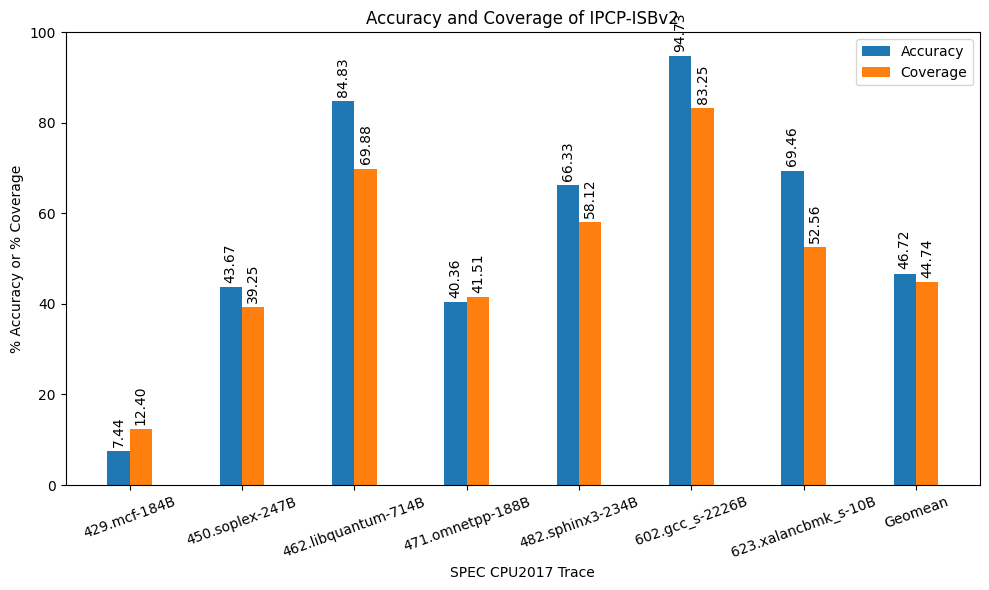

In [65]:
# Plotting the speedups
plt.rcParams.update({'font.size': 10})
x = np.arange(len(trace_names))  # X axis positions for the traces
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each configuration
for i, config in enumerate(configs):  # Skip baseline
    _values = [acc_cov_values[trace][config] for trace in trace_names]
    bars = ax.bar(x + i*width, _values, width, label=config)
    
    # Annotate bars with speedup values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Add labels and titles
ax.set_xlabel('SPEC CPU2017 Trace')
ax.set_ylabel('% Accuracy or % Coverage')
ax.set_ylim(0.0, 100.0)
ax.set_title('Accuracy and Coverage of IPCP-ISBv2')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(trace_names, rotation=20)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
